In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# 1. Data Preparation & Analysis

## 1.1 Data Preparation

In [2]:
airbnb_df = pd.read_csv("/Users/zhangqian/Desktop/BAIT 509 Mahcine Learning/Final Project/AB_NYC_2019.csv")
airbnb_df.info()

airbnb_df['last_review'] = pd.to_datetime(airbnb_df['last_review'])
airbnb_df['days_since_last_review'] = (pd.Timestamp('2019-12-31') - airbnb_df['last_review']).dt.days
airbnb_df['reviews_per_month'] = airbnb_df['reviews_per_month'].replace(np.nan, 0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [3]:
airbnb_df['last_review'] = pd.to_datetime(airbnb_df['last_review'])
airbnb_df['days_since_last_review'] = (pd.Timestamp('2019-12-31') - airbnb_df['last_review']).dt.days
airbnb_df['reviews_per_month'] = airbnb_df['reviews_per_month'].replace(np.nan, 0)
airbnb_df=airbnb_df.drop(['last_review','name','host_name'],axis=1)

In [4]:
airbnb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   host_id                         48895 non-null  int64  
 2   neighbourhood_group             48895 non-null  object 
 3   neighbourhood                   48895 non-null  object 
 4   latitude                        48895 non-null  float64
 5   longitude                       48895 non-null  float64
 6   room_type                       48895 non-null  object 
 7   price                           48895 non-null  int64  
 8   minimum_nights                  48895 non-null  int64  
 9   number_of_reviews               48895 non-null  int64  
 10  reviews_per_month               48895 non-null  float64
 11  calculated_host_listings_count  48895 non-null  int64  
 12  availability_365                

In [5]:
X = airbnb_df.drop(['price','id','host_id','neighbourhood'], axis=1)
y = airbnb_df['price']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16)

## 1.2 Exploratory Data Analysis

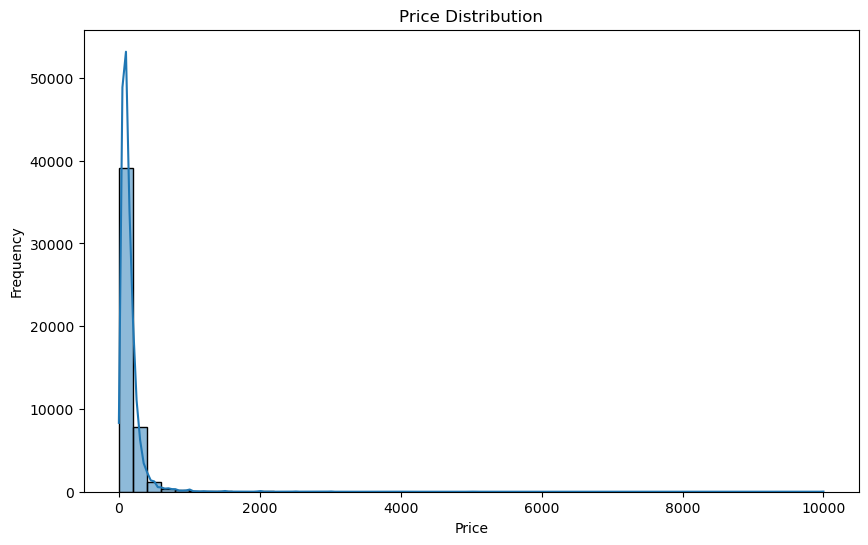

In [6]:
# Price distribution
plt.figure(figsize=(10, 6))
sns.histplot(y, bins=50, kde=True)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.savefig('price_distribution.png') 
plt.show()

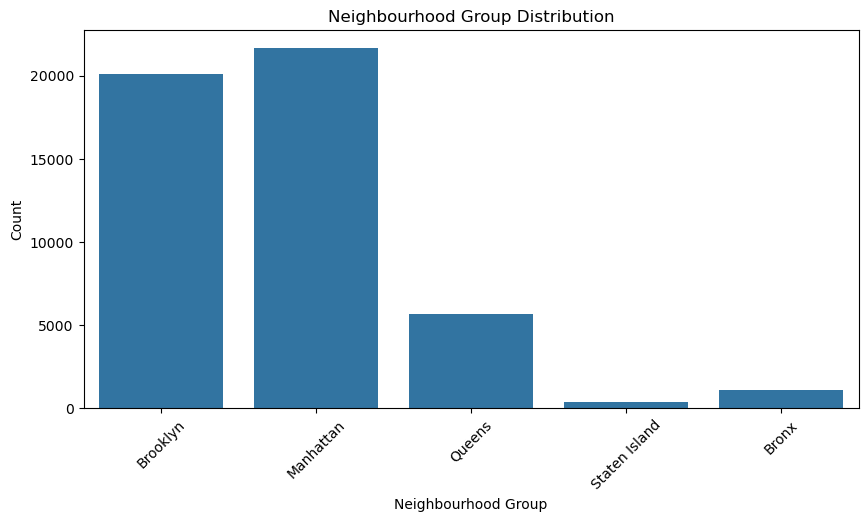

In [7]:
# Neighbourhood Group distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=X, x='neighbourhood_group')
plt.title('Neighbourhood Group Distribution')
plt.xlabel('Neighbourhood Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.25)
plt.savefig('Neighbourhood Group Distribution.png') 
plt.show()

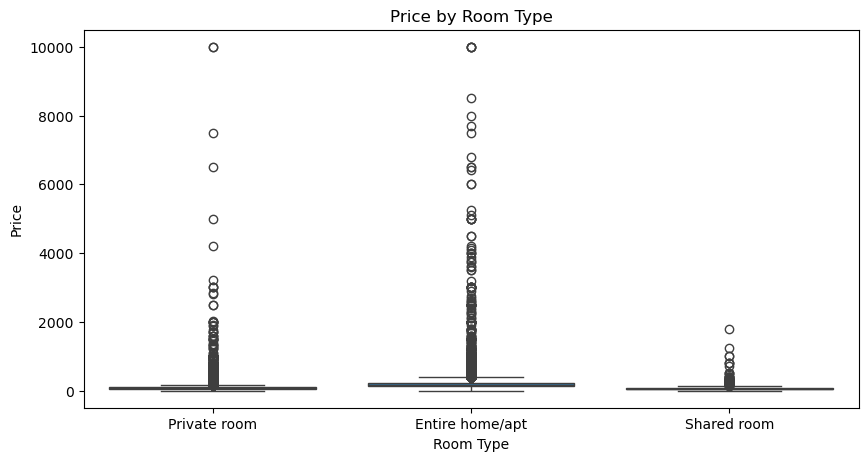

In [8]:
# Relationship between price and room type
plt.figure(figsize=(10, 6))
sns.boxplot(data=airbnb_df, x='room_type', y='price')
plt.title('Price by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Price')
plt.subplots_adjust(bottom=0.25)
plt.savefig('Price by Room Type.png') 
plt.show()

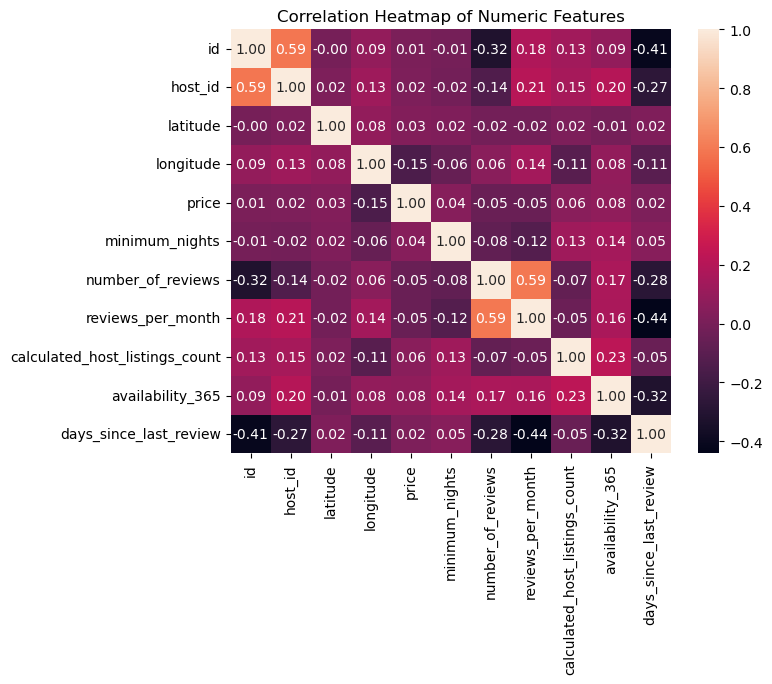

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Select only numeric columns for correlation calculation
numeric_df = airbnb_df.select_dtypes(include=[np.number])

# Generate the correlation matrix for numeric columns only
corr_matrix = numeric_df.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.title('Correlation Heatmap of Numeric Features')
plt.subplots_adjust(bottom=0.35, left=0.35)
plt.savefig('Correlation Heatmap.png')
plt.show()

# 2. Data Preprocessing

## 2.1 Custom a imputer with max value + 1
Citation: https://stackoverflow.com/questions/44575114/building-a-custom-scikit-learn-imputer

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin

class MaxPlusOneImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.max_plus_one_ = np.nanmax(X) + 1
        return self

    def transform(self, X):
        return X.fillna(self.max_plus_one_)

    def get_feature_names_out(self, input_features=None):
        return input_features

##  2.2 Column Transformer

In [11]:
numeric_features = X_train.select_dtypes('int64','float64').columns
categorical_features = X_train.select_dtypes('object').columns

In [12]:
preprocessor = ColumnTransformer(
    transformers=[
        ('review', make_pipeline(MaxPlusOneImputer(), StandardScaler()), ['days_since_last_review']),
        ('numeric', StandardScaler(), numeric_features),
        ('categorical',OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ],
    remainder='passthrough'
)

# 3. Regression Models' Error Analysis

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.compose import make_column_selector
from xgboost import XGBRegressor
import pandas as pd
import matplotlib.pyplot as plt

# Define transformers for numeric and categorical columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Define the preprocessor as a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, make_column_selector(dtype_include=['int64', 'float64'])),
        ('cat', categorical_transformer, make_column_selector(dtype_include='object'))
    ])

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16)

# Initialize and fit the models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Decision Trees': DecisionTreeRegressor(max_depth=5, min_samples_split=20, random_state=16),
    'Random Forests': RandomForestRegressor(n_estimators=100, random_state=16),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=16),
    'XG Boosting': XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=16, objective='reg:squarederror')
}

results = []

for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append({
        'Model': name,
        'MSE': mse,
        'MAE': mae,
        'R^2': r2
    })

results_df = pd.DataFrame(results)
results_df

,Model,MSE,MAE,R^2
0,Linear Regression,48546.540873,73.892266,0.116364
1,Ridge Regression,48546.904554,73.890197,0.116357
2,Lasso Regression,48570.762828,73.778320,0.115923
3,Decision Trees,48308.711618,71.077627,0.120693
4,Random Forests,48490.194412,67.619705,0.117389
5,Gradient Boosting,46967.914942,67.415962,0.145098
6,XG Boosting,46194.800954,65.609415,0.159170


# 4. Building a Model

## 4.1 Dummy Regressor

In [14]:
from sklearn.dummy import DummyRegressor
dummy_pipeline = make_pipeline(
    preprocessor,
    DummyRegressor(strategy='median') 
)

In [15]:
dummy_pipeline.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1467a4be0>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x146cc67a0>)])),
                ('dummyregressor', DummyRegressor(strategy='median'))])

In [16]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

scoring={
    "neg_mse": "neg_mean_squared_error",    
    "neg_rmse": "neg_root_mean_squared_error",    
    "mape_score": 'neg_mean_absolute_percentage_error',
    "r2": "r2",
}

In [17]:
dummy_scores_df = pd.DataFrame(
    cross_validate(
        dummy_pipeline,
        X_train,
        y_train, 
        scoring=scoring,
        cv=5, 
        return_train_score=True
    )
)

dummy_scores_df

,fit_time,score_time,test_neg_mse,train_neg_mse,test_neg_rmse,train_neg_rmse,test_mape_score,train_mape_score,test_r2,train_r2
0,0.042272,0.012852,-65716.597648,-59325.160456,-256.352487,-243.567569,-2.417576e+14,-7.555892e+13,-0.039018,-0.038412
1,0.037228,0.010104,-38990.924326,-66006.569520,-197.461197,-256.917437,-6.044714e+13,-1.208904e+14,-0.055799,-0.036037
2,0.036792,0.009884,-86606.262048,-53871.058096,-294.289419,-232.101396,-5.773609e-01,-1.385922e+14,-0.026381,-0.039003
3,0.036530,0.009997,-54582.210277,-61991.593903,-233.628359,-248.981112,-1.220457e+14,-1.067865e+14,-0.038622,-0.036547
4,0.038032,0.011955,-56837.418382,-61545.088582,-238.405995,-248.082826,-1.208943e+14,-1.057791e+14,-0.039997,-0.038182


## 4.2 Hyperparameter Tuning
### 4.2.1 Decision Tree Regressor

In [18]:
from sklearn.tree import DecisionTreeRegressor
decisiontree_pipeline = make_pipeline(
    preprocessor,
    DecisionTreeRegressor() 
)

In [19]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distributions = {
    "decisiontreeregressor__max_depth": randint(1, 50), 
    "decisiontreeregressor__min_samples_split": randint(2, 20),  
    "decisiontreeregressor__min_samples_leaf": randint(1, 20) 
}

decisiontree_random_search = RandomizedSearchCV(
    decisiontree_pipeline,
    param_distributions,
    cv=3, 
    return_train_score=True,
    n_jobs=-1,
    n_iter=200,
    scoring='r2',
    random_state=16
);
decisiontree_random_search.fit(X_train, y_train);

In [20]:
decisiontree_random_search.score(X_train, y_train)

0.15092947651899502

In [21]:
decisiontree_random_search.best_score_

0.09420934170912439

### 4.2.2 Ridge Regression

In [22]:
from sklearn.linear_model import Ridge
ridge_pipeline = make_pipeline(
    preprocessor,
    Ridge() 
)

In [23]:
param_grid = {
    "ridge__alpha": [0.01, 0.1, 1.0, 5.0, 10.0, 50.0, 100.0, 1000.0]
}

ridge_random_search = RandomizedSearchCV(
    ridge_pipeline,
    param_grid,
    cv=3, 
    return_train_score=True,
    n_jobs=-1,
    scoring='r2',
    random_state=16
)

ridge_random_search.fit(X_train, y_train)

/Users/zhangqian/anaconda3/envs/509/lib/python3.10/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x1467a4be0>),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(fill_value='missing',
                                                                                                              strategy='constant')),
                                                                                               ('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x146cc67a0>)])),
                                             ('ridge', Ridge())]),
                   n_jobs=-1,
                   param_distributions={'ridge__alpha': [0.01, 0.1, 1.0, 5.0,
                                                         10.0, 50.0, 100.0,
                                                         1000.0]},
                   random_state=16, return_train_score=True, scoring='r2')

In [24]:
ridge_random_search.score(X_train, y_train)

0.09419110653877028

In [25]:
ridge_random_search.best_score_

0.0967282965594503

### 4.2.3 Lasso Regression

In [26]:
from sklearn.linear_model import Lasso
lasso_pipeline = make_pipeline(
    preprocessor,
    Lasso() 
)

In [27]:
param_grid= {
    "lasso__alpha": [0.001, 0.01, 0.1, 1.0, 10.0, 20.0, 50.0, 100.0]
}

lasso_random_search = RandomizedSearchCV(
    lasso_pipeline,
    param_grid,
    cv=3,
    return_train_score=True,
    n_jobs=-1,
    scoring='r2',
    random_state=16
)

lasso_random_search.fit(X_train, y_train)

/Users/zhangqian/anaconda3/envs/509/lib/python3.10/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/zhangqian/anaconda3/envs/509/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.970e+07, tolerance: 1.642e+05
  model = cd_fast.enet_coordinate_descent(
/Users/zhangqian/anaconda3/envs/509/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.302e+07, tolerance: 1.325e+05
  model = cd_fast.enet_coordinate_de

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x1467a4be0>),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(fill_value='missing',
                                                                                                              strategy='constant')),
                                                                                               ('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x146cc67a0>)])),
                                             ('lasso', Lasso())]),
                   n_jobs=-1,
                   param_distributions={'lasso__alpha': [0.001, 0.01, 0.1, 1.0,
                                                         10.0, 20.0, 50.0,
                                                         100.0]},
                   random_state=16, return_train_score=True, scoring='r2')

In [28]:
lasso_random_search.score(X_train, y_train)

0.09419110241326889

In [29]:
lasso_random_search.best_score_

0.09672885530829627

### 4.2.4 XGBoost Regression

In [30]:
from xgboost import XGBRegressor

xgb_pipeline = make_pipeline(
    preprocessor,
    XGBRegressor()
)

param_distributions = {
    "xgbregressor__n_estimators": list(range(100, 1001, 100)),
    "xgbregressor__max_depth": list(range(1, 11, 1)), 
    "xgbregressor__learning_rate": [0.01, 0.05, 0.1, 0.2], 
    "xgbregressor__subsample":  [0.5, 0.75, 1] 
}

xgb_random_search = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions,
    cv=3,
    return_train_score=True,
    n_jobs=-1,
    n_iter=50,
    scoring='r2',
    random_state=16
)

xgb_random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x1467a4be0>),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(fill_value='missing',
                                                                                                              strategy='constant...
                                                           num_parallel_tree=None,
                                                           random_state=None, ...))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'xgbregressor__learning_rate': [0.01,
                                                                        0.05,
                                                                        0.1,
                                                                        0.2],
                                        'xgbregressor__max_depth': [1, 2, 3, 4,
                                                                    5, 6, 7, 8,
                                                                    9, 10],
                                        'xgbregressor__n_estimators': [100, 200,
                                                                       300, 400,
                                                                       500, 600,
                                                                       700, 800,
                                                                       900,
                                                                       1000],
                                        'xgbregressor__subsample': [0.5, 0.75,
                                                                    1]},
                   random_state=16, return_train_score=True, scoring='r2')

In [31]:
xgb_random_search.score(X_train, y_train)

0.5641835510294582

In [32]:
xgb_random_search.best_score_

0.17045035847543977

## 4.3 Model Selection and Results

In [33]:
model_scores = {
    'Decision Tree': decisiontree_random_search.best_score_,
    'Ridge': ridge_random_search.best_score_,
    'Lasso': lasso_random_search.best_score_,
    'XGBoost': xgb_random_search.best_score_
}

df_model_scores = pd.DataFrame(list(model_scores.items()), columns=['Model', 'Best Score'])

print(df_model_scores.sort_values(by='Best Score',ascending=False))

           Model  Best Score
3        XGBoost    0.170450
2          Lasso    0.096729
1          Ridge    0.096728
0  Decision Tree    0.094209


In [34]:
xgb_random_search.best_params_

{'xgbregressor__subsample': 0.75,
 'xgbregressor__n_estimators': 300,
 'xgbregressor__max_depth': 5,
 'xgbregressor__learning_rate': 0.05}

In [35]:
feature_importances=xgb_random_search.best_estimator_.named_steps['xgbregressor'].feature_importances_

In [36]:
feature_names = xgb_random_search.best_estimator_.named_steps['columntransformer'].get_feature_names_out()
feature_names = [name.split('__')[-1] for name in feature_names]
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

                              Feature  Importance
13          room_type_Entire home/apt    0.218888
7              days_since_last_review    0.119617
5      calculated_host_listings_count    0.103006
0                            latitude    0.100658
10      neighbourhood_group_Manhattan    0.086321
2                      minimum_nights    0.067565
1                           longitude    0.057874
9        neighbourhood_group_Brooklyn    0.052714
3                   number_of_reviews    0.043892
6                    availability_365    0.042790
4                   reviews_per_month    0.038869
11         neighbourhood_group_Queens    0.033190
14             room_type_Private room    0.025208
15              room_type_Shared room    0.009408
8           neighbourhood_group_Bronx    0.000000
12  neighbourhood_group_Staten Island    0.000000


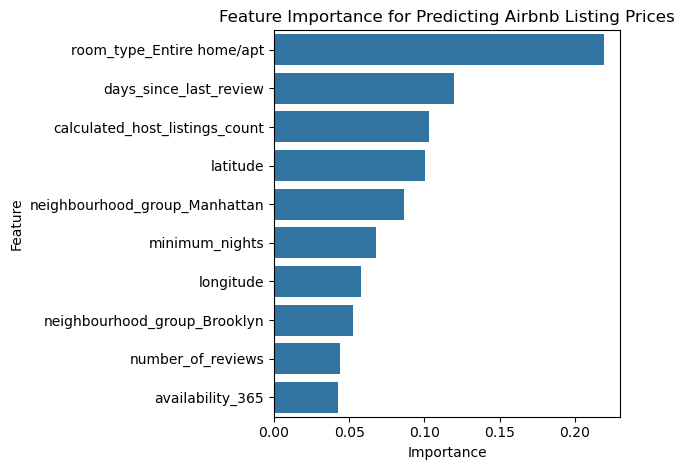

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(x="Importance", y="Feature", data=feature_importance_df.head(10))
plt.title('Feature Importance for Predicting Airbnb Listing Prices')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [38]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, mae, r2

model_performance = []

models = [
    ('Dummy Regressor', dummy_pipeline),
    ('XG Boosting', xgb_random_search.best_estimator_)
]

for name, model in models:
    mse, mae, r2 = evaluate_model(model, X_train, X_test, y_train, y_test)
    model_performance.append({'Model': name, 'MSE': mse, 'MAE': mae, 'R^2': r2})

performance_df = pd.DataFrame(model_performance)
performance_df

,Model,MSE,MAE,R^2
0,Dummy Regressor,57336.233971,84.999284,-0.043625
1,XG Boosting,46783.444979,66.037995,0.148455
